# Problem Set 10

Victoria Gregory, N14207660

4/24/2016

This week's homework pertains to the model from Matsuyama, Sushko, and Gardini (2014). This paper models the dynamics of global innovation cycles in a two-country model. The dynamical system we will simulate is the following:

$$
\begin{cases} 
      n_{1t+1} = \delta(\frac{\theta}{2} + (1-\theta) n_{1t}) & n_{t1} \leq \frac{1}{2}, n_{t2} \leq \frac{1}{2} \\
      n_{2t+1} = \delta(\frac{\theta}{2} + (1-\theta) n_{2t}) &  \\
      n_{1t+1} = \delta n_{1t} & n_{1t} \geq h(n_{2t}), n_{2t} \geq h(n_{1t}) \\
      n_{2t+1} = \delta n_{2t} & \\
      n_{1t+1} = \delta n_{1t} & n_{1t} \geq \frac{1}{2}, n_{2t} \leq h(n_{1t}) \\
      n_{2t+1} = \delta(\theta h(n_{1t}) + (1-\theta) n_{2t}) & \\
      n_{1t+1} = \delta(\theta h(n_{2t}) + (1-\theta) n_{1t}) & n_{1t} \leq h(n_{1t}), n_{2t} \geq \frac{1}{2} \\
      n_{2t+1} = \delta n_{2t} &
   \end{cases}
$$

where $h(n)$ is defined by $\frac{1}{h(n) + \rho n} + \frac{1}{h(n) + \frac{n}{\rho}} = 2$.

$n_{1t}$ and $n_{2t}$ are the varieties of products in countries 1 and 2, $\theta$ is a measure of monopolistic varieties, $\delta$ is a shock that represents the probability that a variety survives and carries over to the next period, and $\rho$ measures how much final goods producers spend on an imported variety, relative to what they would spend in the absence of trade costs.

The goal of this exercise is to find which initial states lead to synchronization, how long it takes to get there, and how this changes with $\rho$. To do this, I will simulate the dynamical system in Python.

First, import all necessary packages and set up the parameters that won't change.

In [85]:
import numpy as np
import scipy.optimize as optimize
from scipy.interpolate import UnivariateSpline
from numpy.linalg import norm as am
import plotly.plotly as py
from plotly.graph_objs import *
from plotly import tools

# set up parameters
theta = 2.5
delta = 0.7
grid_size_n = 1000
grid_size_sim = 100
max_sims = 1000

The first function I create will solve for $h(n)$ for the given $\rho$ value and for a given $n$. 

In [86]:
def h_n(n,rho):
    
    def resid(x):
        return 1.0/(x + rho*n) + 1.0/(x+n/rho) - 2
    sol = optimize.bisect(resid, 0, 1)
    return sol

The next function solves for $h(n)$ over a grid of $n$, then sets up a spline interpolant for $h(n)$ what will be called during the simulation.

In [87]:
def setup_h_n(rho):
    
    # solve for h(n) on a grid
    n_grid = np.linspace(0.000001,1,grid_size_n)
    hn_grid = np.zeros(grid_size_n)
    for i in range(len(n_grid)):
        hn_grid[i] = h_n(n_grid[i],rho)
    
    # interpolate h(n)
    spl = UnivariateSpline(n_grid, hn_grid, k=5)
    return spl

The next function runs a simulation for a given initial condition and $\rho$ value, using the system above. After each step, it checks for convergence. Once it converges, it checks to see if the two countries are synchronized or asynchronized. The function also accepts a maximum number of simulations to run in case the system never acheives convergence. It returns the simulation paths for both countries. In addition, if the countries are synchronized, it returns the number of periods it took to achieve synchronization.

In [88]:
def simulate(n1start, n2start, rho, max_sims):
    
    # create the interpolant for given rho
    spl = setup_h_n(rho)

    # vectors to fill with states along simulation
    n1 = np.zeros(max_sims)
    n2 = np.zeros(max_sims)
    n1[0] = n1start
    n2[0] = n2start

    for t in range(0, max_sims-1):

        # check where we are in the state space and update accordingly
        if n1[t] <= 0.5 and n2[t] <= 0.5:
            n1[t+1] = delta*(theta/2 + (1-theta)*n1[t])
            n2[t+1] = delta*(theta/2 + (1-theta)*n2[t])

        elif n1[t] >= spl(n2[t]) and n2[t] >= spl(n1[t]):
            n1[t+1] = delta*n1[t]
            n2[t+1] = delta*n2[t]

        elif n1[t] >= 0.5 and n2[t] <= spl(n1[t]):
            n1[t+1] = delta*n1[t]
            n2[t+1] = delta*(theta*spl(n1[t]) + (1-theta)*n2[t])

        else:
            n1[t+1] = delta*(theta*spl(n2[t]) + (1-theta)*n1[t])
            n2[t+1] = delta*n2[t]

        # check for convergence
        if t >= 1:
            check = np.array([n1[t+1] - n1[t-1], n2[t+1] - n2[t-1]])
            if am(check) < 1e-10:
                break

    # cut off excess zeros
    n1 = n1[0:t+1]
    n2 = n2[0:t+1]

    # check to see if syncronized
    if np.isclose(n1[t], n2[t], 1e-4):
        sync = t+1
    else:
        sync = np.nan
    return n1, n2, sync


Now I set up a grid for the state space's initial conditions, as well as a grid for the $\rho$'s we will simulate for. For each initial condition and each $\rho$, I record the number of periods it took to acheive synchronization or a NaN if it never does. Then I set up a trace object for plotting.

In [89]:
n_grid_init = np.linspace(0.000001, 1, grid_size_sim)
n1g, n2g = np.meshgrid(n_grid_init, n_grid_init)
rho_grid = np.array([0.2, 0.4, 0.6, 0.8])
sync = np.zeros((grid_size_sim, grid_size_sim, len(rho_grid)))

for r in range(0, len(rho_grid)):
    # record simulation outcome for the given rho
    for i in range(0, grid_size_sim):
        for j in range(0, grid_size_sim):
            n_1, n_2, s = simulate(n1g[i,j], n2g[i,j], rho_grid[r], max_sims)
            sync[i,j,r] = s

In [90]:
fig = tools.make_subplots(rows=2, cols=2, 
    subplot_titles=('$\\rho = 0.2$', '$\\rho = 0.4$', '$\\rho = 0.6$', '$\\rho = 0.8$'))
tx = np.array([1, 1, 2, 2])
ty = np.array([1, 2, 1, 2])
for r in range(0, len(rho_grid)):
    
    # make trace object for the given rho
    trace = Contour(
        x=n_grid_init,
        y=n_grid_init,
        z=sync[:,:,r],
        autocolorscale=False,
        autocontour=False,
        colorscale='Portland',
        connectgaps=False,
        contours=Contours(
            coloring='fill',
            end=250,
            showlines=False,
            size=10,
            start=100),
        line=Line(
            smoothing=1),
        ncontours=20,
        zauto=True,
        zmax=250,
        zmin=100)
    
    # append trace object to subplot figure object
    fig.append_trace(trace, tx[r], ty[r])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [91]:
fig['layout'].update(height=700, width=700)
py.iplot(fig, filename='plots_PS10')

Static image because the HTML one won't show up in the PDF:

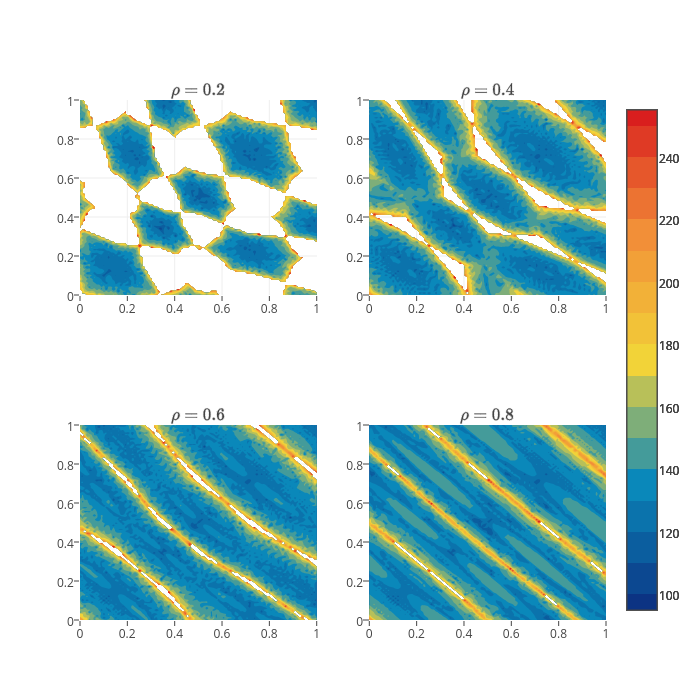

In [93]:
py.image.ishow(fig)